In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [3]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, init_planes=64):
        super(ResNet, self).__init__()
        self.in_planes = init_planes

        self.conv1 = nn.Conv2d(3, init_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(init_planes)
        self.layer1 = self._make_layer(block, init_planes, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, init_planes * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, init_planes * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, init_planes * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(init_planes * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, init_planes=42)

def test():
    net = ResNet18(num_classes=10)
    y = net(torch.randn(1, 3, 32, 32))
    print("Output shape:", y.size())
    print("Total parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))

test()

Output shape: torch.Size([1, 10])
Total parameters: 4815940


In [5]:
# Transformations with data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Normal transformation for testing, no augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 datasets with transformations
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:01<00:00, 109121479.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, test_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Adjusts LR every 10 epochs
    
    best_accuracy = 0  # Initialize the best accuracy for model saving
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_test += (predicted == labels).sum().item()
                total_test += labels.size(0)

        test_accuracy = 100 * correct_test / total_test
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)
        
        scheduler.step()  # Update the learning rate

        
        print(f'Epoch {epoch + 1} | Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy:.2f}% | Test Loss: {test_loss / len(test_loader):.3f} | Test Accuracy: {test_accuracy:.2f}%')

        # Save the model if it has the best accuracy so far
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved better model with test accuracy: {best_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies

# Initialize your model
model = ResNet18()

# Training parameters
epochs = 100
learning_rate = 0.1

# Start training and evaluation
train_losses, train_accuracies, test_losses, test_accuracies = train_and_evaluate(model, trainloader, testloader, epochs, learning_rate)

Epoch 1 | Train Loss: 1.863 | Train Accuracy: 30.98% | Test Loss: 1.588 | Test Accuracy: 41.09%
Saved better model with test accuracy: 41.09%
Epoch 2 | Train Loss: 1.419 | Train Accuracy: 48.33% | Test Loss: 1.299 | Test Accuracy: 53.31%
Saved better model with test accuracy: 53.31%
Epoch 3 | Train Loss: 1.178 | Train Accuracy: 58.31% | Test Loss: 0.996 | Test Accuracy: 64.79%
Saved better model with test accuracy: 64.79%
Epoch 4 | Train Loss: 1.059 | Train Accuracy: 62.68% | Test Loss: 1.038 | Test Accuracy: 64.14%
Epoch 5 | Train Loss: 0.942 | Train Accuracy: 67.11% | Test Loss: 0.828 | Test Accuracy: 72.49%
Saved better model with test accuracy: 72.49%
Epoch 6 | Train Loss: 0.868 | Train Accuracy: 69.84% | Test Loss: 0.751 | Test Accuracy: 74.50%
Saved better model with test accuracy: 74.50%
Epoch 7 | Train Loss: 0.826 | Train Accuracy: 71.36% | Test Loss: 0.921 | Test Accuracy: 70.27%
Epoch 8 | Train Loss: 0.806 | Train Accuracy: 71.90% | Test Loss: 0.828 | Test Accuracy: 72.63%
Ep

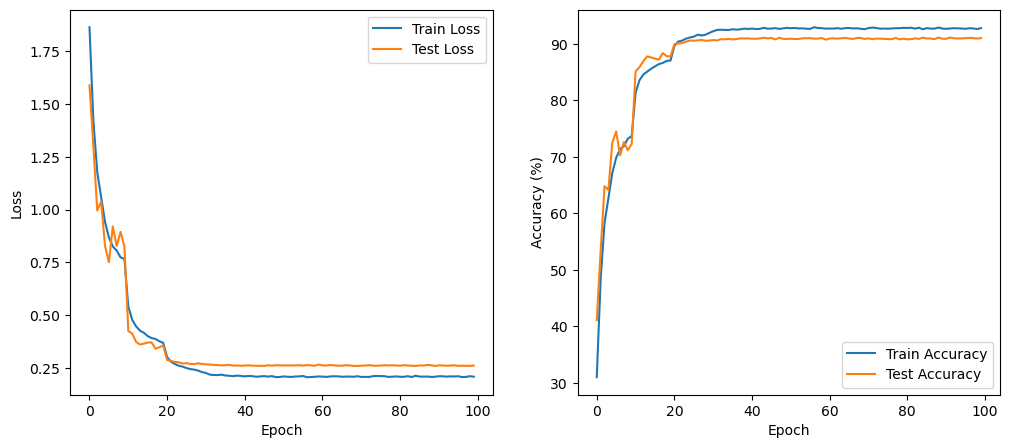

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [9]:
import torch
from torchvision import transforms
from PIL import Image
import csv
import pickle

model_state_dict = torch.load('best_model.pth')

model = ResNet18()  
model.load_state_dict(model_state_dict)

model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

with open('cifar_test_nolabels.pkl', 'rb') as file:
    test_images = pickle.load(file)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

predictions = []
for i in range(len(test_images[b'data'])):
    image_data = test_images[b'data'][i].reshape(3, 32, 32).transpose([1, 2, 0])
    image_data = transform(image_data).unsqueeze(0)  # Add batch dimension

    image_data = image_data.to(device)

    with torch.no_grad():
        output = model(image_data)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
        predictions.append((test_images[b'ids'][i], predicted_label))

csv_file_path = 'predictions.csv'
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['ID', 'Labels'])  # Write the header
    for prediction in predictions:
        writer.writerow(prediction)

csv_file_path

'predictions.csv'